In [70]:
from twelvedata import TDClient
import pandas as pd
import matplotlib.pyplot as plt
td = TDClient(apikey="682541201d9f435f8b138b00b2d09797")

sym = "AAPL"
inter = "1day"

df = td.time_series(
    symbol=sym,
    interval=inter,
    outputsize=3000
).as_pandas()


In [71]:
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter for dates between 2015 and 2020 (inclusive)
df = df[(df['datetime'] >= '2015-01-01') & (df['datetime'] <= '2020-12-31')]

df

,datetime,open,high,low,close,volume
1049,2020-12-31,134.08000,134.74001,131.72000,132.6900,99116600
1050,2020-12-30,135.58000,135.99001,133.39999,133.7200,96452100
1051,2020-12-29,138.05000,138.78999,134.34000,134.8700,121047300
1052,2020-12-28,133.99001,137.34000,133.50999,136.6900,124486200
1053,2020-12-24,131.32001,133.46001,131.10001,131.9700,54930100
...,...,...,...,...,...,...
2555,2015-01-08,27.30750,28.03750,27.17500,27.9725,237458000
2556,2015-01-07,26.80000,27.05000,26.67500,26.9375,160423600
2557,2015-01-06,26.63500,26.85750,26.15750,26.5650,263188400
2558,2015-01-05,27.07250,27.16250,26.35250,26.5625,257142000


In [72]:
import finnhub
finnhub_client = finnhub.Client(api_key="cv677upr01qi7f6onrqgcv677upr01qi7f6onrr0")

print(finnhub_client.earnings_calendar(_from="2000-06-10", to="2021-06-30", symbol="AAPL"))


{'earningsCalendar': []}


In [73]:
df = df.sort_values(by='datetime')

# Calculate daily percentage change
df['daily_pct_change'] = df['close'].pct_change().abs() * 100

# Resample the data to get weekly and monthly data
df_weekly = df.resample('W', on='datetime').last()  # Resample weekly, using last available close price
df_monthly = df.resample('M', on='datetime').last()  # Resample monthly, using last available close price

# Calculate weekly and monthly percentage changes
df_weekly['weekly_pct_change'] = df_weekly['close'].pct_change().abs() * 100
df_monthly['monthly_pct_change'] = df_monthly['close'].pct_change().abs() * 100

df_weekly = df_weekly.reset_index()
df_monthly = df_monthly.reset_index()

# Function to count occurrences of percentage changes in given ranges
def count_change_ranges(df, column, ranges):
    change_counts = {f"{low}-{high}%": 0 for low, high in ranges}
    
    for change in df[column].dropna():
        for low, high in ranges:
            if low <= change < high:
                change_counts[f"{low}-{high}%"] += 1
                break  # Stop once the change falls within the range

    return change_counts

# Define the change percentage ranges (0-1%, 1-2%, 2-3%, etc.)
change_ranges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),(9,10),(10,15),(15,20),(20,100),(100,1000)]

# Count occurrences of percentage changes for daily, weekly, and monthly periods
daily_change_counts = count_change_ranges(df, 'daily_pct_change', change_ranges)
weekly_change_counts = count_change_ranges(df_weekly, 'weekly_pct_change', change_ranges)
monthly_change_counts = count_change_ranges(df_monthly, 'monthly_pct_change', change_ranges)

daily_df = pd.DataFrame(list(daily_change_counts.items()), columns=['Change Range', 'Count'])
weekly_df = pd.DataFrame(list(weekly_change_counts.items()), columns=['Change Range', 'Count'])
monthly_df = pd.DataFrame(list(monthly_change_counts.items()), columns=['Change Range', 'Count'])


# Output results
print("Daily Change Counts:", daily_df)
print("Weekly Change Counts:", weekly_df)
print("Monthly Change Counts:", monthly_df)

Daily Change Counts:    Change Range  Count
0          0-1%    853
1          1-2%    366
2          2-3%    159
3          3-4%     66
4          4-5%     29
5          5-6%     14
6          6-7%     11
7          7-8%      3
8         9-10%      3
9        10-15%      4
10       15-20%      0
11      20-100%      0
12    100-1000%      0
Weekly Change Counts:    Change Range  Count
0          0-1%     79
1          1-2%     67
2          2-3%     51
3          3-4%     40
4          4-5%     26
5          5-6%     19
6          6-7%      7
7          7-8%      8
8         9-10%      1
9        10-15%      8
10       15-20%      1
11      20-100%      0
12    100-1000%      0
Monthly Change Counts:    Change Range  Count
0          0-1%      6
1          1-2%      6
2          2-3%      4
3          3-4%      5
4          4-5%      6
5          5-6%      5
6          6-7%      7
7          7-8%      5
8         9-10%      6
9        10-15%     14
10       15-20%      4
11      20-100

C:\Users\Francois Schoonbee\AppData\Local\Temp\ipykernel_27704\1894263789.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='datetime').last()  # Resample monthly, using last available close price


In [74]:
len(df)

1511

In [75]:
sum(monthly_df['Count'])

69

In [76]:
def find_95_cutoff(df, column):
    sorted_changes = df[column].dropna().sort_values()
    cumulative_sum = sorted_changes.cumsum() / sorted_changes.sum()
    cutoff_value = sorted_changes[cumulative_sum >= 0.90].iloc[0]
    return cutoff_value

# Find the 95% cutoff for daily, weekly, and monthly absolute changes
daily_95_cutoff = find_95_cutoff(df, 'daily_pct_change')
weekly_95_cutoff = find_95_cutoff(df_weekly, 'weekly_pct_change')
monthly_95_cutoff = find_95_cutoff(df_monthly, 'monthly_pct_change')

# Output results
print(f"95% Cutoff for Daily Changes: {daily_95_cutoff}")
print(f"95% Cutoff for Weekly Changes: {weekly_95_cutoff}")
print(f"95% Cutoff for Monthly Changes: {monthly_95_cutoff}")

95% Cutoff for Daily Changes: 5.811948473476014
95% Cutoff for Weekly Changes: 11.01031440288307
95% Cutoff for Monthly Changes: 18.404459471808465


In [77]:
df_weekly

,datetime,open,high,low,close,volume,daily_pct_change,weekly_pct_change
0,2015-01-04,27.84750,27.86000,26.83750,27.3325,212818400,NaN,NaN
1,2015-01-11,28.16750,28.31250,27.55250,28.0025,214798000,0.107248,2.451294
2,2015-01-18,26.75750,26.89500,26.30000,26.4975,314053200,0.777008,5.374520
3,2015-01-25,28.07500,28.43750,27.88250,28.2450,185859200,0.516014,6.594962
4,2015-02-01,29.60000,30.00000,29.21250,29.2900,334982000,1.463415,3.699770
...,...,...,...,...,...,...,...,...
309,2020-12-06,122.60000,122.86000,121.52000,122.2500,78260400,0.561249,4.854619
310,2020-12-13,122.43000,122.76000,120.55000,122.4100,86939800,0.673483,0.130879
311,2020-12-20,128.96001,129.10001,126.12000,126.6600,192541500,1.585082,3.471939
312,2020-12-27,131.32001,133.46001,131.10001,131.9700,54930100,0.771220,4.192326


In [78]:
daily_above_cutoff = df[df['daily_pct_change'] > daily_95_cutoff]
weekly_above_cutoff = df_weekly[df_weekly['weekly_pct_change'] > weekly_95_cutoff]
monthly_above_cutoff = df_monthly[df_monthly['monthly_pct_change'] > monthly_95_cutoff]

# Output results
print(f"Changes above the 95% cutoff for Daily Changes:\n{daily_above_cutoff[['datetime', 'daily_pct_change']]}")
print(f"Changes above the 95% cutoff for Weekly Changes:\n{weekly_above_cutoff[['datetime', 'weekly_pct_change']]}")
print(f"Changes above the 95% cutoff for Monthly Changes:\n{monthly_above_cutoff[['datetime', 'monthly_pct_change']]}")

Changes above the 95% cutoff for Daily Changes:
       datetime  daily_pct_change
2399 2015-08-21          6.116289
2291 2016-01-27          6.570657
2228 2016-04-27          6.257786
2165 2016-07-27          6.496328
2035 2017-02-01          6.098063
1658 2018-08-01          5.891008
1592 2018-11-02          6.633066
1557 2018-12-26          7.042158
1552 2019-01-03          9.960740
1534 2019-01-30          6.833463
1263 2020-02-27          6.536819
1261 2020-03-02          9.310067
1256 2020-03-09          7.909214
1255 2020-03-10          7.202164
1253 2020-03-12          9.875467
1252 2020-03-13         11.980824
1251 2020-03-16         12.864698
1247 2020-03-20          6.348558
1245 2020-03-24         10.032536
1236 2020-04-06          8.723748
1155 2020-07-31         10.468864
1131 2020-09-03          8.006081
1129 2020-09-08          6.729497
1105 2020-10-12          6.352056
Changes above the 95% cutoff for Weekly Changes:
      datetime  weekly_pct_change
69  2016-05-01     

In [79]:
daily_above_cutoff

,datetime,open,high,low,close,volume,daily_pct_change
2399,2015-08-21,27.6075,27.9750,26.4125,26.4400,513102000,6.116289
2291,2016-01-27,24.0100,24.1575,23.3350,23.3550,533478800,6.570657
2228,2016-04-27,24.0000,24.6775,23.9200,24.4550,458408400,6.257786
2165,2016-07-27,26.0675,26.0875,25.6875,25.7375,369379200,6.496328
2035,2017-02-01,31.7575,32.6225,31.7525,32.1875,447940000,6.098063
1658,2018-08-01,49.7825,50.4400,49.3275,50.3750,271742800,5.891008
1592,2018-11-02,52.3875,53.4125,51.3575,51.8700,365314800,6.633066
1557,2018-12-26,37.0750,39.3075,36.6800,39.2925,234330000,7.042158
1552,2019-01-03,35.9950,36.4300,35.5000,35.5475,365248800,9.960740
1534,2019-01-30,40.8125,41.5375,40.0575,41.3125,244439200,6.833463


In [80]:
weekly_above_cutoff

,datetime,open,high,low,close,volume,daily_pct_change,weekly_pct_change
69,2016-05-01,23.4975,23.6800,23.1275,23.4350,274126000,1.149425,11.298259
89,2016-09-18,28.7800,29.0325,28.5100,28.7300,319547600,0.562430,11.432173
174,2018-05-06,44.5625,46.0625,44.5425,45.9575,224805200,3.923342,13.251602
269,2020-03-01,64.3150,69.6025,64.0925,68.3400,426510000,0.058497,12.678486
272,2020-03-22,61.7950,62.9575,57.0000,57.3100,401693200,6.348558,17.530669
291,2020-08-02,102.8850,106.4150,100.8250,106.2600,374336800,10.468864,14.733035


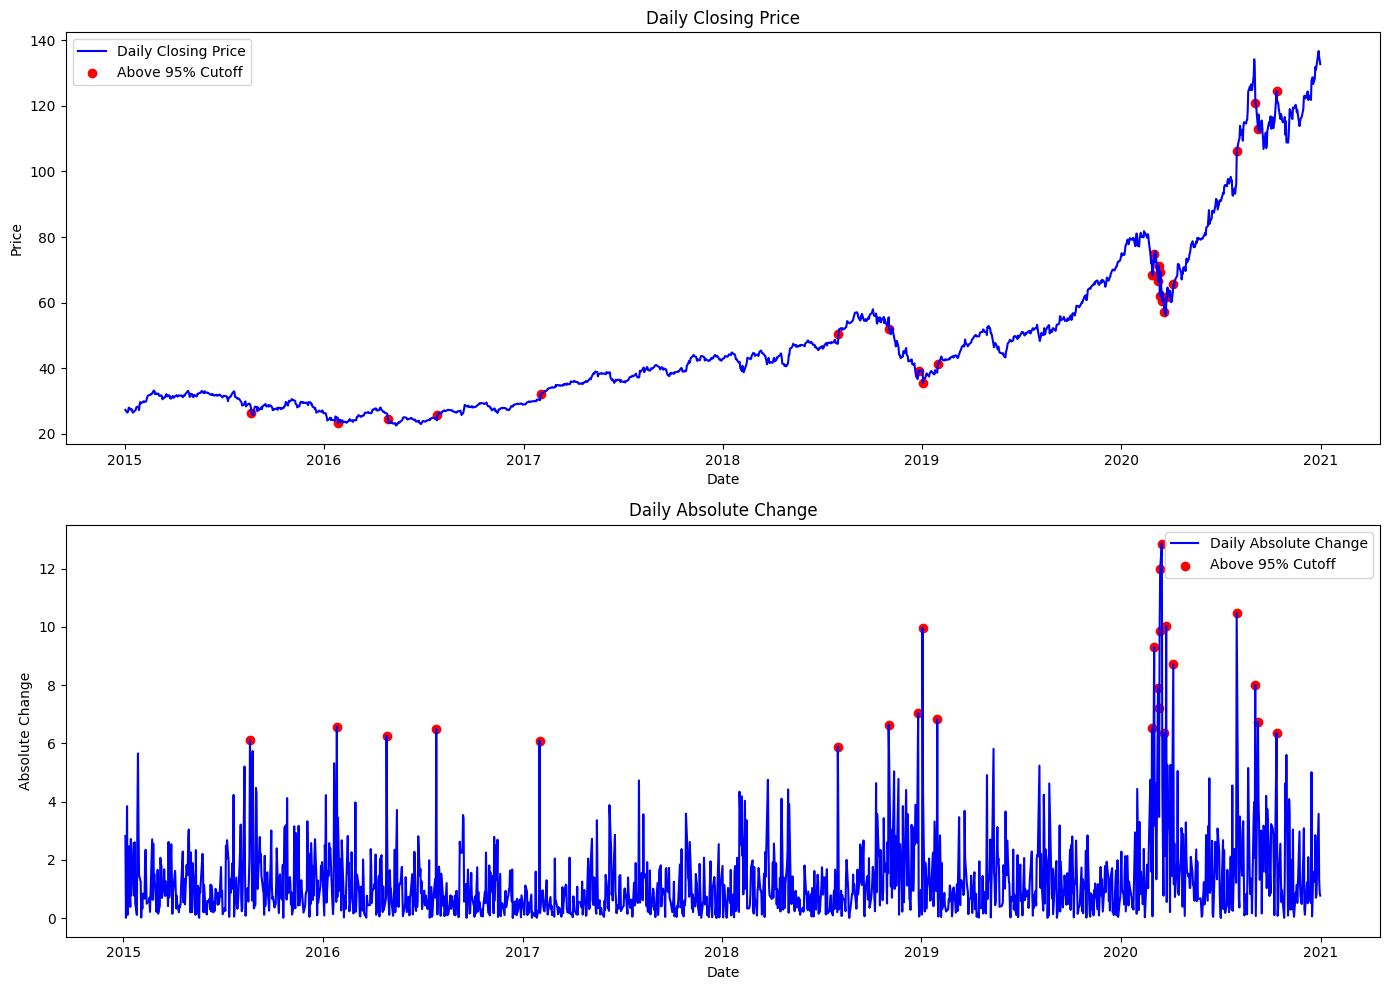

In [81]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Plot daily data
axs[0].plot(df['datetime'], df['close'], label='Daily Closing Price', color='blue')
axs[0].scatter(daily_above_cutoff['datetime'], daily_above_cutoff['close'], color='red', label='Above 95% Cutoff')
axs[0].set_title('Daily Closing Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot daily change
axs[1].plot(df['datetime'], df['daily_pct_change'], label='Daily Absolute Change', color='blue')
axs[1].scatter(daily_above_cutoff['datetime'], daily_above_cutoff['daily_pct_change'], color='red', label='Above 95% Cutoff')
axs[1].set_title('Daily Absolute Change')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Absolute Change')
axs[1].legend()

plt.tight_layout()
plt.show()


In [82]:
weekly_above_cutoff

,datetime,open,high,low,close,volume,daily_pct_change,weekly_pct_change
69,2016-05-01,23.4975,23.6800,23.1275,23.4350,274126000,1.149425,11.298259
89,2016-09-18,28.7800,29.0325,28.5100,28.7300,319547600,0.562430,11.432173
174,2018-05-06,44.5625,46.0625,44.5425,45.9575,224805200,3.923342,13.251602
269,2020-03-01,64.3150,69.6025,64.0925,68.3400,426510000,0.058497,12.678486
272,2020-03-22,61.7950,62.9575,57.0000,57.3100,401693200,6.348558,17.530669
291,2020-08-02,102.8850,106.4150,100.8250,106.2600,374336800,10.468864,14.733035


<function matplotlib.pyplot.show(close=None, block=None)>

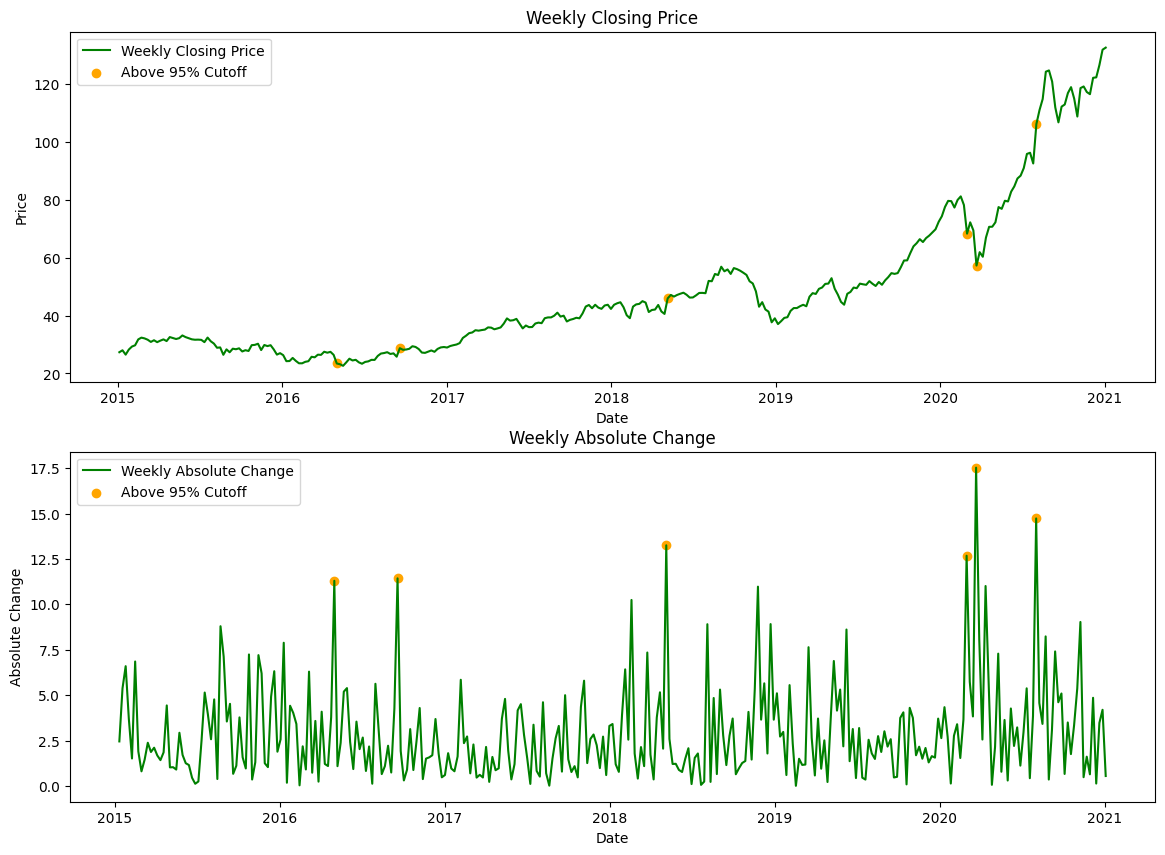

In [83]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
# Plot weekly data
axs[0].plot(df_weekly['datetime'], df_weekly['close'], label='Weekly Closing Price', color='green')
axs[0].scatter(weekly_above_cutoff['datetime'], weekly_above_cutoff['close'], color='orange', label='Above 95% Cutoff')
axs[0].set_title('Weekly Closing Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot weekly change
axs[1].plot(df_weekly['datetime'], df_weekly['weekly_pct_change'], label='Weekly Absolute Change', color='green')
axs[1].scatter(weekly_above_cutoff['datetime'], weekly_above_cutoff['weekly_pct_change'], color='orange', label='Above 95% Cutoff')
axs[1].set_title('Weekly Absolute Change')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Absolute Change')
axs[1].legend()
plt.show

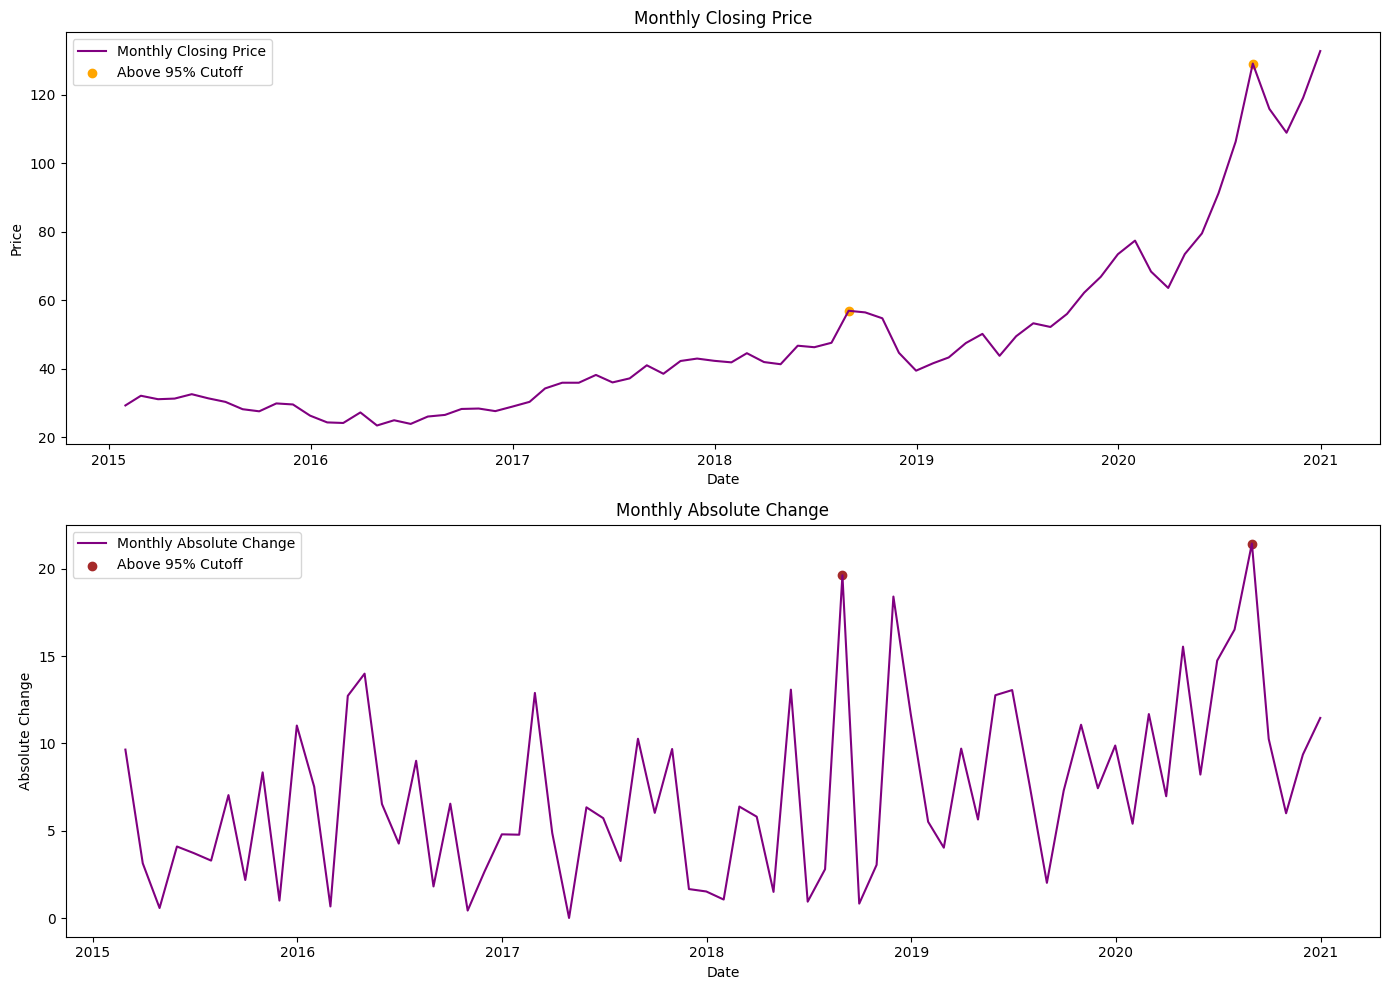

In [84]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
# Plot monthly data
axs[0].plot(df_monthly['datetime'], df_monthly['close'], label='Monthly Closing Price', color='purple')
axs[0].scatter(monthly_above_cutoff['datetime'], monthly_above_cutoff['close'], color='orange', label='Above 95% Cutoff')
axs[0].set_title('Monthly Closing Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot monthly change
axs[1].plot(df_monthly['datetime'], df_monthly['monthly_pct_change'], label='Monthly Absolute Change', color='purple')
axs[1].scatter(monthly_above_cutoff['datetime'], monthly_above_cutoff['monthly_pct_change'], color='brown', label='Above 95% Cutoff')
axs[1].set_title('Monthly Absolute Change')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Absolute Change')
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

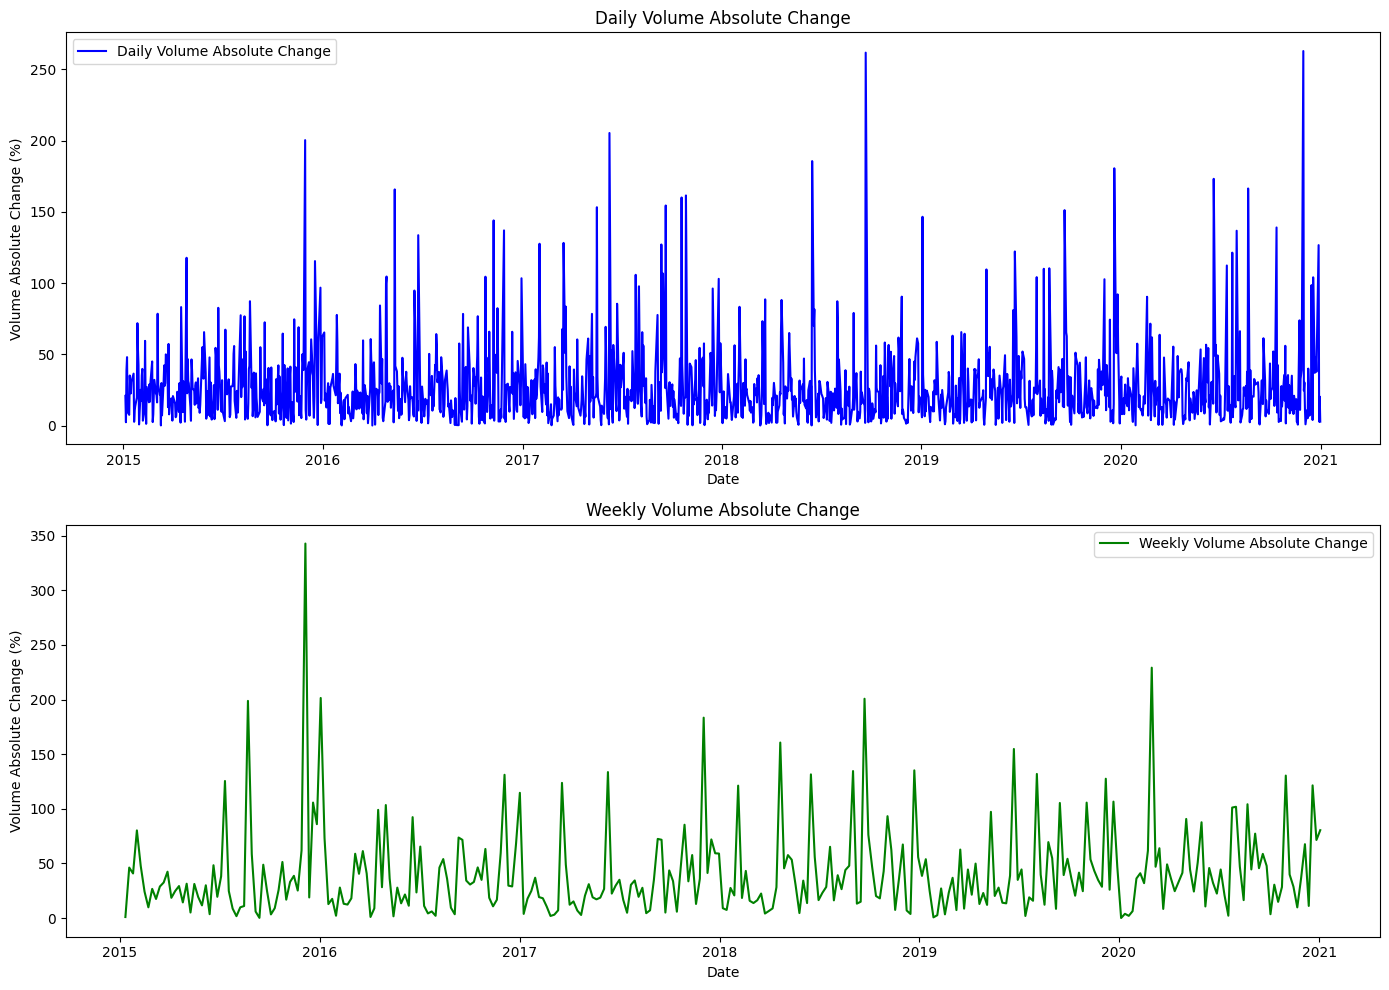

In [85]:
# Calculate daily percentage change for volume
df['daily_volume_pct_change'] = df['volume'].pct_change().abs() * 100

# Resample the data to get weekly and monthly data for volume
df_weekly['weekly_volume_pct_change'] = df_weekly['volume'].pct_change().abs() * 100
df_monthly['monthly_volume_pct_change'] = df_monthly['volume'].pct_change().abs() * 100

# Plot daily, weekly, and monthly volume percentage changes
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Plot daily volume change
axs[0].plot(df['datetime'], df['daily_volume_pct_change'], label='Daily Volume Absolute Change', color='blue')
axs[0].set_title('Daily Volume Absolute Change')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Volume Absolute Change (%)')
axs[0].legend()

# Plot weekly volume change
axs[1].plot(df_weekly['datetime'], df_weekly['weekly_volume_pct_change'], label='Weekly Volume Absolute Change', color='green')
axs[1].set_title('Weekly Volume Absolute Change')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volume Absolute Change (%)')
axs[1].legend()

plt.tight_layout()
plt.show()


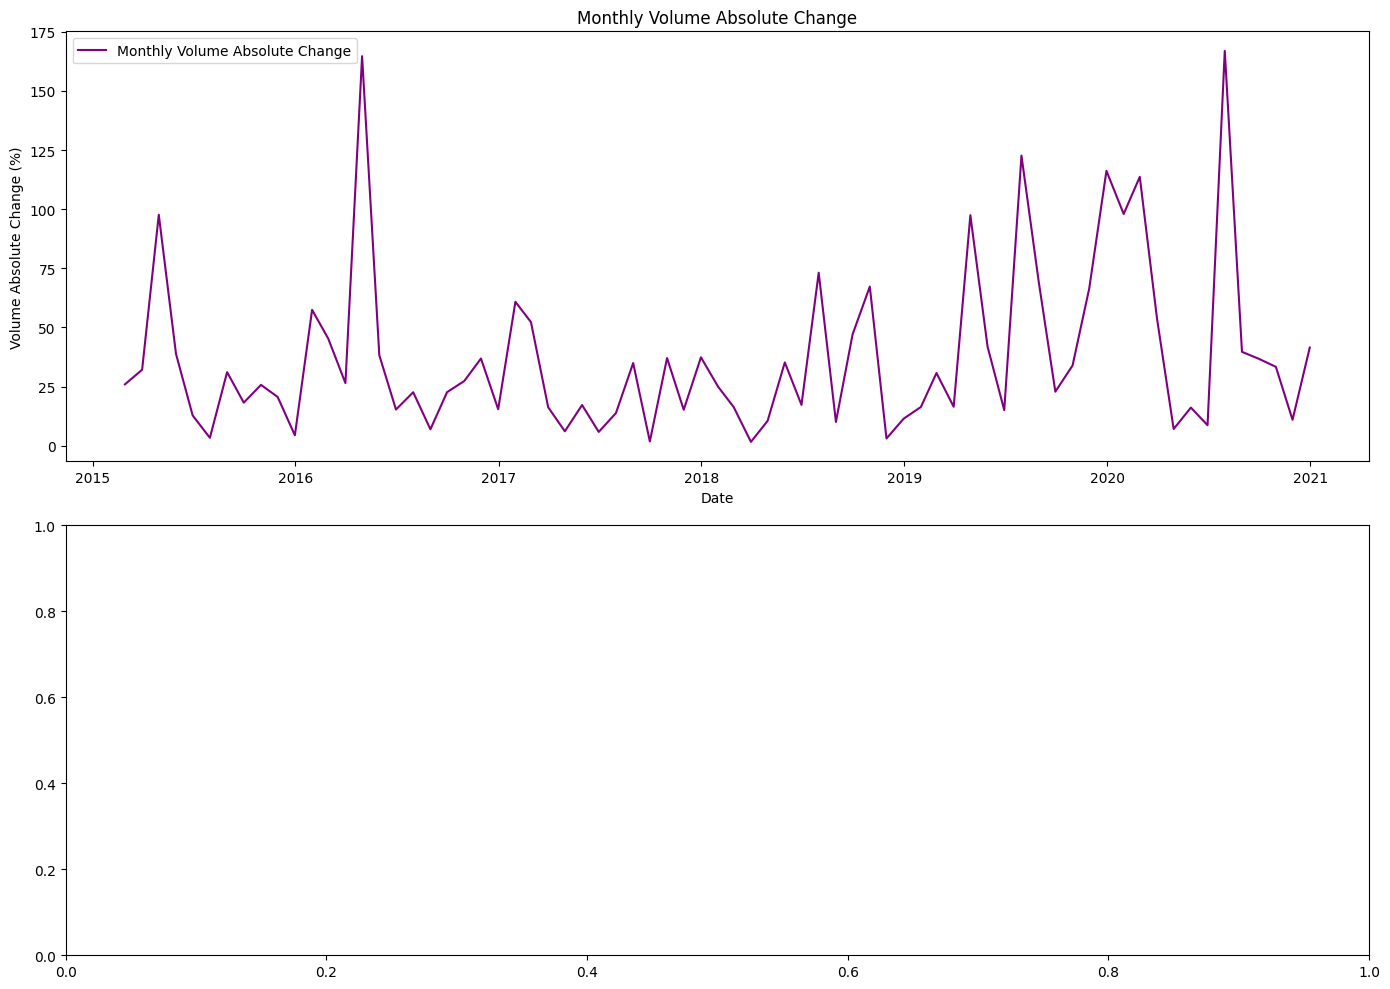

In [86]:

# Plot monthly volume change
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

axs[0].plot(df_monthly['datetime'], df_monthly['monthly_volume_pct_change'], label='Monthly Volume Absolute Change', color='purple')
axs[0].set_title('Monthly Volume Absolute Change')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Volume Absolute Change (%)')
axs[0].legend()

plt.tight_layout()
plt.show()